In [1]:
import os 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import splitfolders

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
base_path = r"C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\archive\asl_dataset/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
print("number of elements = ", len(df))

number of elements =  2515


In [3]:
splitfolders.ratio(r'C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\archive\asl_dataset',output=r'C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\workingDir', seed=1333, ratio=(0.8,0.1,0.1))

Copying files: 2515 files [00:16, 154.62 files/s]


In [ ]:
# import shutil
# shutil.rmtree(r"C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\workingDir\test")
# shutil.rmtree(r"C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\workingDir\train")
# shutil.rmtree(r"C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\workingDir\val")

In [4]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

In [5]:
train_path = r"C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\workingDir\train"
val_path = r"C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\workingDir\val"
test_path = r"C:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\workingDir\test"

batch = 32
image_size = 200
img_channel = 3
n_classes = 36

In [6]:
train_data = datagen.flow_from_directory(directory= train_path, 
                                         target_size=(image_size,image_size), 
                                         batch_size = batch, 
                                         class_mode='categorical')

val_data = datagen.flow_from_directory(directory= val_path, 
                                       target_size=(image_size,image_size), 
                                       batch_size = batch, 
                                       class_mode='categorical',
                                       )

test_data = datagen.flow_from_directory(directory= test_path, 
                                         target_size=(image_size,image_size), 
                                         batch_size = batch, 
                                         class_mode='categorical',
                                         shuffle= False)

Found 2012 images belonging to 36 classes.
Found 251 images belonging to 36 classes.
Found 252 images belonging to 36 classes.


In [7]:
model = Sequential()
# input layer
# Block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(Conv2D(64,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))

#Block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.4))

# fully connected layer
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(36, activation='softmax'))



model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                        

In [8]:
early_stoping = EarlyStopping(monitor='val_loss', 
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True, 
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience = 2, 
                                         factor=0.5 , 
                                         verbose = 1)

In [9]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [10]:
asl_class = model.fit(train_data, 
                      validation_data= val_data, 
                      epochs=30, 
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)



Epoch 1/30
63/63 [==============================] - 102s 2s/step - loss: 2.7005 - accuracy: 0.2634 - val_loss: 0.6655 - val_accuracy: 0.7649 - lr: 0.0010
Epoch 2/30
63/63 [==============================] - 95s 2s/step - loss: 0.7707 - accuracy: 0.7664 - val_loss: 0.2765 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 3/30
63/63 [==============================] - 92s 1s/step - loss: 0.3311 - accuracy: 0.8862 - val_loss: 0.1823 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 4/30
63/63 [==============================] - 93s 1s/step - loss: 0.2200 - accuracy: 0.9299 - val_loss: 0.1526 - val_accuracy: 0.9482 - lr: 0.0010
Epoch 5/30
63/63 [==============================] - 93s 1s/step - loss: 0.1347 - accuracy: 0.9597 - val_loss: 0.1385 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 6/30
63/63 [==============================] - 93s 1s/step - loss: 0.0939 - accuracy: 0.9697 - val_loss: 0.1023 - val_accuracy: 0.9602 - lr: 0.0010
Epoch 7/30
63/63 [==============================] - 94s 1s/step - loss: 0.0964 - 

In [11]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 99.9502956867218
The Loss of the model for training data is: 0.0007713723462074995
The accuracy of the model for validation data is: 98.40637445449829
The Loss of the model for validation data is: 0.07997511327266693


In [13]:
# prediction
result = model.predict(test_data,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_data.labels

# Evaluvate
loss,acc = model.evaluate(test_data,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 94.84127163887024
The Loss of the model for testing data is: 0.3377110958099365


In [14]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 239
Incorrect predicted classes: 13


In [15]:
print(classification_report(y_true, y_pred,target_names= categories.values()))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.88      1.00      0.93         7
           2       0.83      0.71      0.77         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       1.00      0.86      0.92         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
           a       1.00      1.00      1.00         7
           b       1.00      0.86      0.92         7
           c       1.00      1.00      1.00         7
           d       1.00      1.00      1.00         7
           e       1.00      1.00      1.00         7
           f       1.00      1.00      1.00         7
           g       1.00      0.86      0.92         7
           h       1.00    

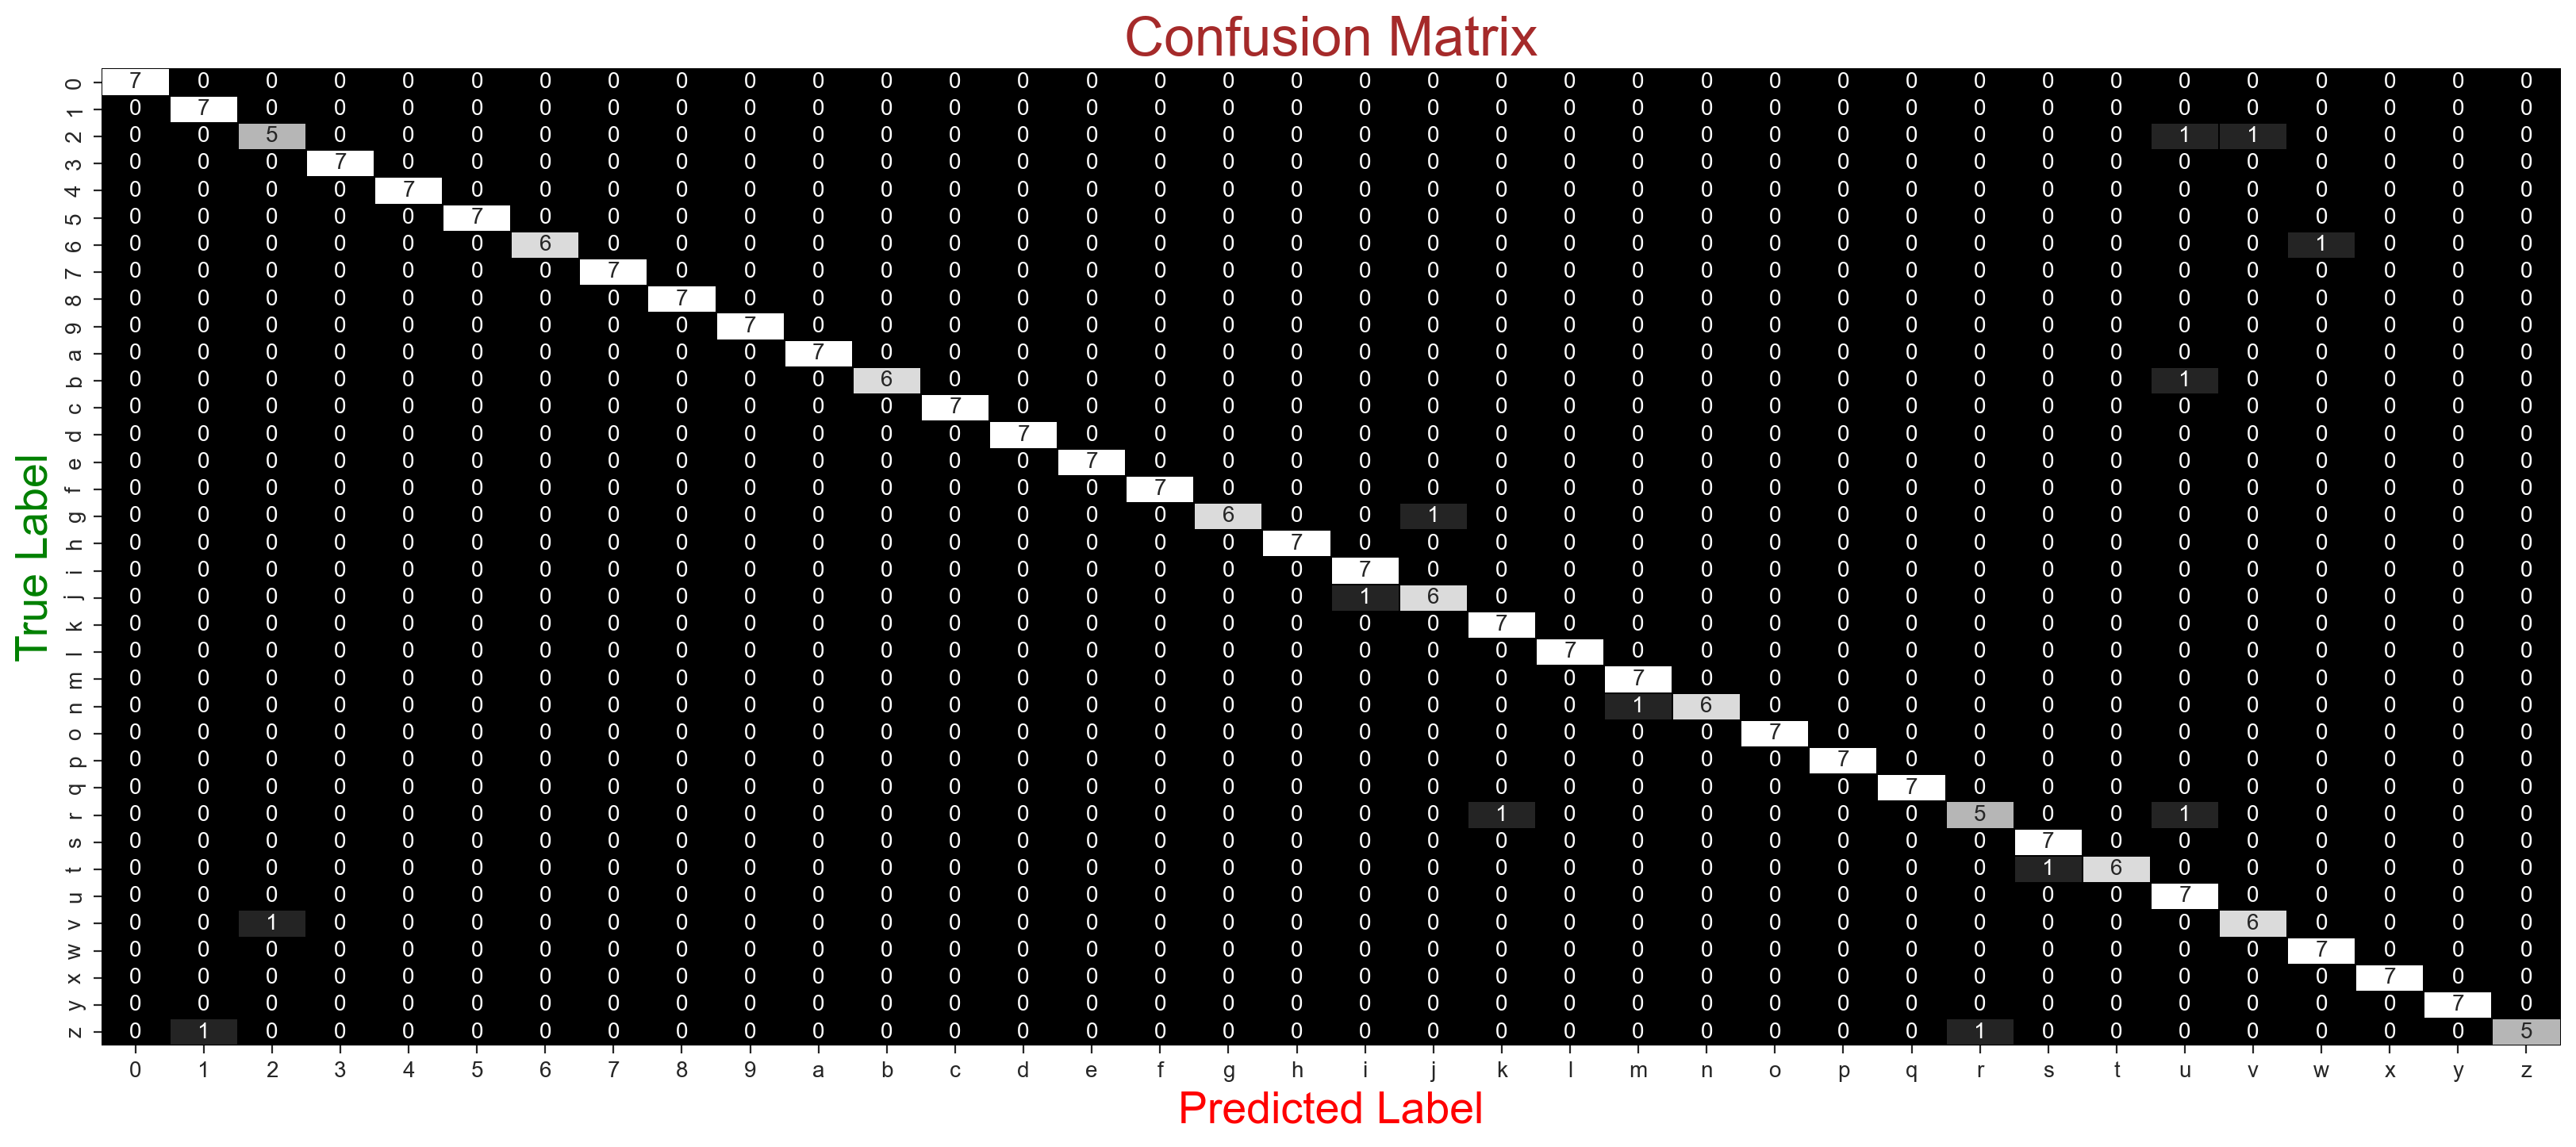

In [16]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred) 

f,ax = plt.subplots(figsize = (20,8),dpi=200)

sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.1, cmap = "gist_yarg_r", 
            linecolor="black", fmt='.0f', ax=ax, 
            cbar=False, xticklabels=categories.values(), 
            yticklabels=categories.values())

plt.xlabel("Predicted Label",fontdict={'color':'red','size':20})
plt.ylabel("True Label",fontdict={'color':'green','size':20})
plt.title("Confusion Matrix",fontdict={'color':'brown','size':25})

plt.show()

In [17]:
model.save("ASL_model.h5")

c:\Users\bkarr\OneDrive\Desktop\Projects\aslToEnglish\.venv\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
